In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from datascope.importance import SklearnModelAccuracy
from datascope.importance.shapley import ShapleyImportance, ImportanceMethod
from sklearn.pipeline import Pipeline

from nde.utility import SklearnPipelineAccuracy
from nde.importances import PipelineImportance

SEED = 18011982
np.random.seed(SEED)

In [2]:
df = pd.read_csv('synthetic_letters_with_attributes.csv')
df

,age,sector,education,letter,label
0,39,academia,NaN,"To Whom It May Concern,\n\nI regret to write t...",negative
1,36,academia,trainee,"To Whom It May Concern,\n\nI regret to inform ...",negative
2,64,finance,college,"To Whom It May Concern,\n\nI am pleased to rec...",positive
3,46,health,trainee,"To whom it may concern,\n\nI am writing to rec...",neutral
4,53,finance,trainee,"To Whom It May Concern,\n\nI regret to inform ...",negative
...,...,...,...,...,...
195,53,finance,trainee,"To whom it may concern,\n\nI regret to inform ...",negative
196,36,finance,college,"To Whom It May Concern,\n\nI regret to inform ...",negative
197,23,finance,college,"Dear [Recipient's Name],\n\nI regret to inform...",negative
198,22,academia,trainee,"To whom it may concern,\n\nI am pleased to rec...",positive


In [3]:
train, rest = train_test_split(df, test_size=0.5, random_state=SEED)
valid, test = train_test_split(rest, test_size=0.5, random_state=SEED)

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer

went_to_college = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('college_or_phd', FunctionTransformer(lambda x: (x == 'college') | (x == 'phd'))),
])

age = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler()),
])

feature_encoding = ColumnTransformer([
    ('at_least_college', went_to_college, ['education']),
    ('sector_one_hot', OneHotEncoder(), ['sector']),    
    ('age', age, ['age']),
    ('encoded_letters', HashingVectorizer(ngram_range=(1, 3), n_features=1000), 'letter'),
], sparse_threshold=0.0)

pipeline = [
    feature_encoding, SGDClassifier(loss='log_loss', random_state=SEED)
]

In [5]:
utility = SklearnPipelineAccuracy(pipeline)
utility(train, train.label, test, test.label).score

0.92

In [6]:
def inject_label_errors(original_labels, fraction):
    labels_with_errors = copy.deepcopy(list(original_labels))
    count = int(len(labels_with_errors) * fraction)
    indices_for_errors = np.random.choice(range(len(labels_with_errors)), count, replace=True)

    possible_labels = list(set(original_labels))
    
    for idx in indices_for_errors:
        true_label = labels_with_errors[idx]
        other_labels = [label for label in possible_labels if label != true_label]
        labels_with_errors[idx] = np.random.choice(other_labels)
    
    return labels_with_errors    

In [7]:
train_mislabeled = inject_label_errors(train.label, fraction=0.5)

utility(train, train_mislabeled, test, test.label).score

0.78

In [8]:
from nde.importances import LooImportance

loo_importance = PipelineImportance(utility, LooImportance)

loo_values = loo_importance.fit(train, train_mislabeled).score(valid, valid.label)

In [9]:
dsv_importance = PipelineImportance(utility, ShapleyImportance, method=ImportanceMethod.NEIGHBOR)

dsvs = dsv_importance.fit(train, train_mislabeled).score(valid, valid.label)

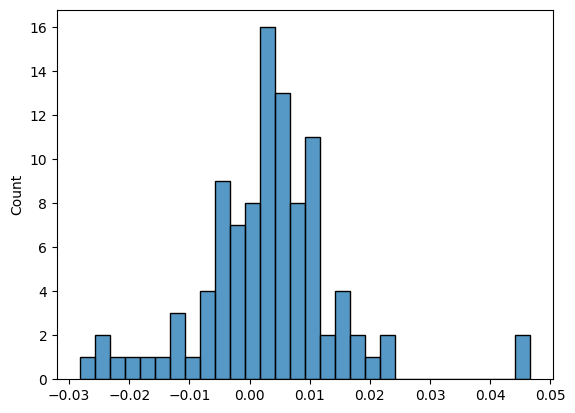

In [10]:
sns.histplot(data=dsvs, binwidth=0.0025)
plt.show()

In [11]:
from IPython.core.display import display, HTML

html = '<ul>'

for index in np.argsort(dsvs)[:5]:
    html += f'''
<li>    
<b>Data Shapley value</b>: {dsvs[index]}<br/>
<b>Given label</b>: {train_mislabeled[index]}<br/>
<b>True label</b>: {train.iloc[index].label}<br/><br/>

<i>Age: {train.iloc[index].age}, Education: {train.iloc[index].education}, Sector: {train.iloc[index].sector}</i><br/><br/>
<i>{train.iloc[index].letter}</i><br/><br/>
</li>
'''

html += '</ul>'
display(HTML(html))

/var/folders/ln/t4s9x03j5nz8x1r5tc40xzr00000gn/T/ipykernel_33970/132349474.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [12]:
def evaluate_repairs(indices_to_repair, train, train_mislabeled, train_labels, test, test_labels, utility):
    true_labels = list(train_labels)
    train_with_repairs = copy.deepcopy(list(train_mislabeled))
    
    scores = []
    for index in indices_to_repair:
        train_with_repairs[index] = true_labels[index]
        score = utility(train, train_with_repairs, test, test_labels).score
        scores.append(score)

    return scores

In [13]:
num_negative_dsvs = np.sum(dsvs < 0)
indices_to_repair_dsv = np.argsort(dsvs)[:num_negative_dsvs]

repair_scores_dsv = evaluate_repairs(indices_to_repair_dsv, train, train_mislabeled, train.label, test, test.label, utility)

In [14]:
random_indices = np.random.choice(range(len(train)), num_negative_dsvs, replace=False)

repair_scores_random = evaluate_repairs(random_indices, train, train_mislabeled, train.label, test, test.label, utility)

In [15]:
loo_indices = np.argsort(loo_values)[:num_negative_dsvs]
loo_indices = [idx for idx in loo_indices if loo_values[idx] < 0.0]

repair_scores_loo = evaluate_repairs(loo_indices, train, train_mislabeled, train.label, test, test.label, utility)

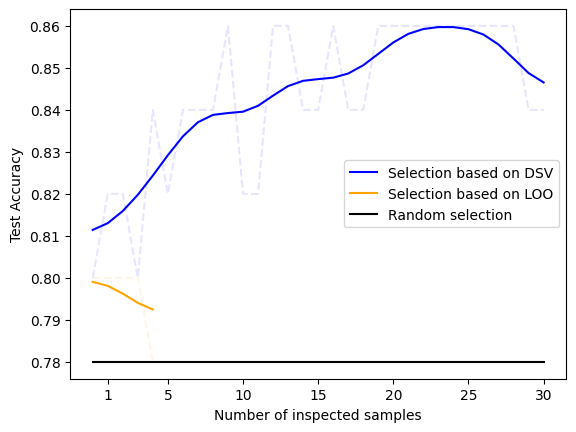

In [18]:
from scipy.ndimage import gaussian_filter1d

alpha = 0.1
sigma = 2

ax = sns.lineplot(repair_scores_dsv, alpha=alpha, color='blue', linestyle='--')
ax = sns.lineplot(gaussian_filter1d(repair_scores_dsv, sigma=sigma), label="Selection based on DSV", color='blue')
ax = sns.lineplot(repair_scores_loo, alpha=alpha, color='orange', linestyle='--')
ax = sns.lineplot(gaussian_filter1d(repair_scores_loo, sigma=sigma), label="Selection based on LOO", color='orange')
ax = sns.lineplot(repair_scores_random, alpha=alpha, color='black', linestyle='--')
ax = sns.lineplot(gaussian_filter1d(repair_scores_random, sigma=sigma), label="Random selection", color='black')


ax.set_xlabel("Number of inspected samples")
ax.set_ylabel("Test Accuracy")
ax.legend()

plt.xticks([1] + list(range(5, len(repair_scores_dsv) + 1, 5)))
plt.show()